<a href="https://colab.research.google.com/github/bkkaggle/pytorch-CycleGAN-and-pix2pix/blob/master/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Take a look at the [repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) for more information

# Install

In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [1]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [ ]:
!pip install -r requirements.txt

# Datasets

Download one of the official datasets with:

-   `bash ./datasets/download_cyclegan_dataset.sh [apple2orange, summer2winter_yosemite, horse2zebra, monet2photo, cezanne2photo, ukiyoe2photo, vangogh2photo, maps, cityscapes, facades, iphone2dslr_flower, ae_photos]`

Or use your own dataset by creating the appropriate folders and adding in the images.

-   Create a dataset folder under `/dataset` for your dataset.
-   Create subfolders `testA`, `testB`, `trainA`, and `trainB` under your dataset's folder. Place any images you want to transform from a to b (cat2dog) in the `testA` folder, images you want to transform from b to a (dog2cat) in the `testB` folder, and do the same for the `trainA` and `trainB` folders.

In [3]:
!bash ./datasets/download_cyclegan_dataset.sh horse2zebra

Specified [horse2zebra]
for details.

--2025-04-30 01:31:17--  http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./datasets/horse2zebra.zip’

./datasets/horse2ze 100%[===================>] 111.45M  3.07MB/s    in 69s     

2025-04-30 01:32:27 (1.61 MB/s) - ‘./datasets/horse2zebra.zip’ saved [116867962/116867962]

Archive:  ./datasets/horse2zebra.zip
   creating: ./datasets/horse2zebra/trainA/
  inflating: ./datasets/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_299.jpg  
  inflating: ./datasets/horse2zebra/t

# Pretrained models

Download one of the official pretrained models with:

-   `bash ./scripts/download_cyclegan_model.sh [apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower]`

Or add your own pretrained model to `./checkpoints/{NAME}_pretrained/latest_net_G.pt`

In [ ]:
!bash ./scripts/download_cyclegan_model.sh horse2zebra

# Training

-   `python train.py --dataroot ./datasets/horse2zebra --name horse2zebra --model cycle_gan`

Change the `--dataroot` and `--name` to your own dataset's path and model's name. Use `--gpu_ids 0,1,..` to train on multiple GPUs and `--batch_size` to change the batch size. I've found that a batch size of 16 fits onto 4 V100s and can finish training an epoch in ~90s.

Once your model has trained, copy over the last checkpoint to a format that the testing model can automatically detect:

Use `cp ./checkpoints/horse2zebra/latest_net_G_A.pth ./checkpoints/horse2zebra/latest_net_G.pth` if you want to transform images from class A to class B and `cp ./checkpoints/horse2zebra/latest_net_G_B.pth ./checkpoints/horse2zebra/latest_net_G.pth` if you want to transform images from class B to class A.


In [13]:
!python train.py --dataroot ./datasets/dataset_for_GAN_cycle_gan --name dataset_for_GAN_cycle_gan --model cycle_gan --display_id -1 

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./datasets/dataset_for_GAN_cycle_gan	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                    

# Testing

-   `python test.py --dataroot datasets/horse2zebra/testA --name horse2zebra_pretrained --model test --no_dropout`

Change the `--dataroot` and `--name` to be consistent with your trained model's configuration.

> from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix:
> The option --model test is used for generating results of CycleGAN only for one side. This option will automatically set --dataset_mode single, which only loads the images from one set. On the contrary, using --model cycle_gan requires loading and generating results in both directions, which is sometimes unnecessary. The results will be saved at ./results/. Use --results_dir {directory_path_to_save_result} to specify the results directory.

> For your own experiments, you might want to specify --netG, --norm, --no_dropout to match the generator architecture of the trained model.

In [25]:
!python test.py --dataroot ./datasets/dataset_for_GAN_cycle_gan/testA --name dataset_for_GAN_cycle_gan --model test --no_dropout --norm instance

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./datasets/dataset_for_GAN_cycle_gan/testA	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                

# Visualize

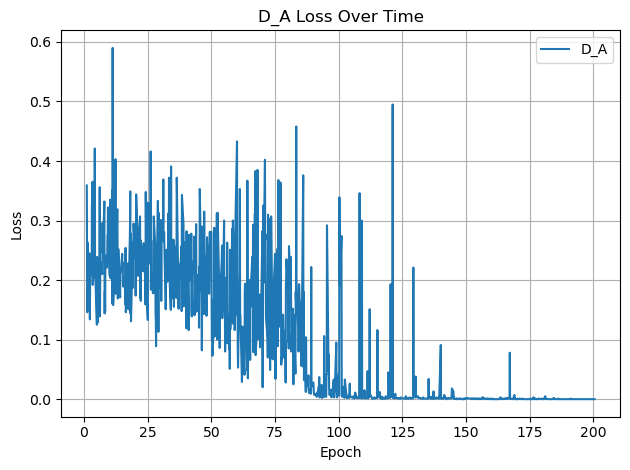

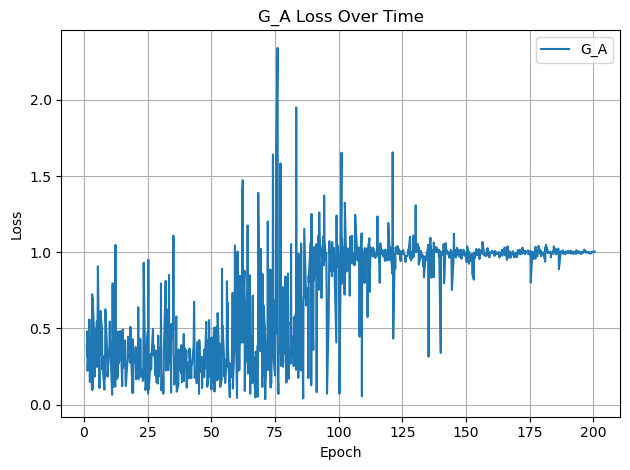

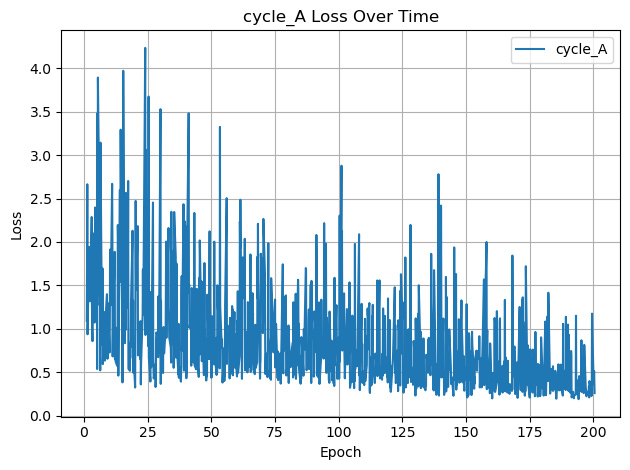

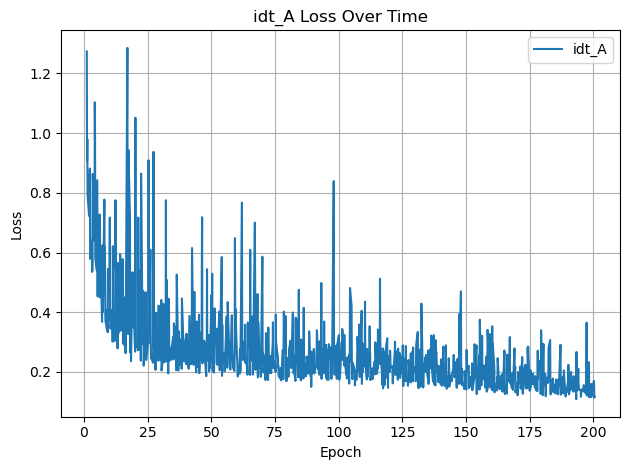

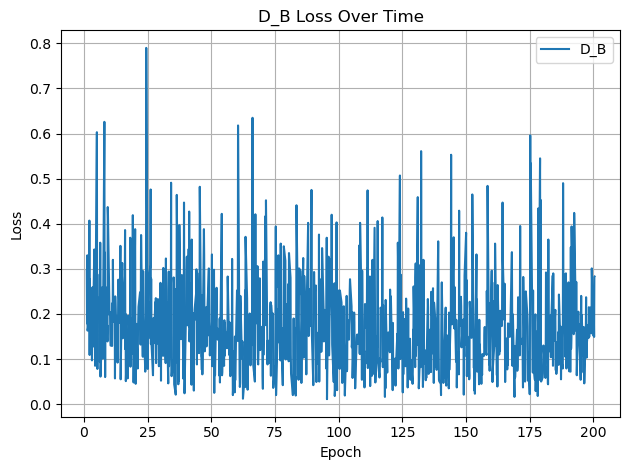

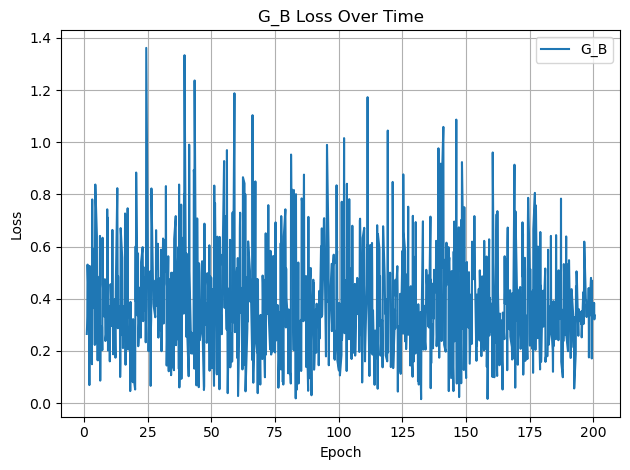

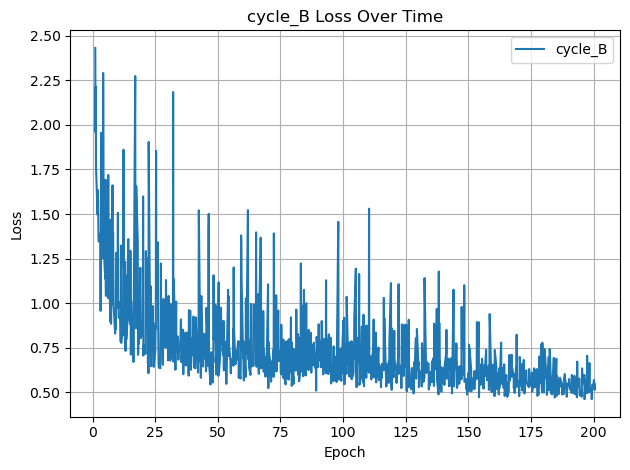

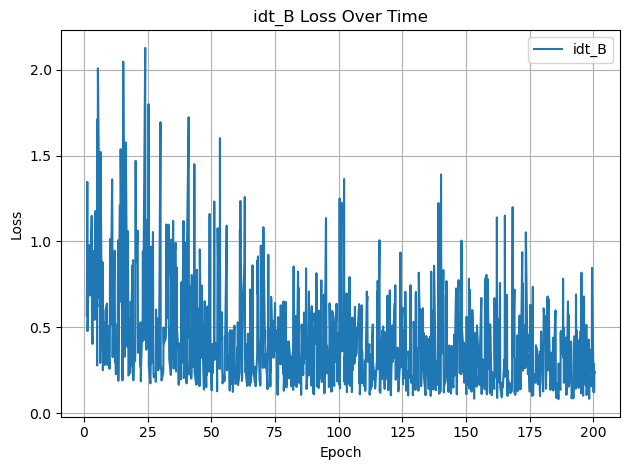

In [19]:
import matplotlib.pyplot as plt
import re
from collections import defaultdict

def parse_loss_log(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    loss_dict = defaultdict(list)
    epochs = []

    for line in lines:
        if line.startswith('('):
            # epoch ve iters değerlerini çıkar
            match = re.search(r'\(epoch: (\d+), iters: (\d+),', line)
            if match:
                epoch = int(match.group(1))
                iters = int(match.group(2))
                epochs.append(epoch + iters / 1000.0)  # Daha hassas bir x ekseni için

                # Kayıp değerlerini çıkar
                parts = line.strip().split(')')[1].strip().split(' ')
                for i in range(0, len(parts), 2):
                    if i + 1 < len(parts):
                        key = parts[i].rstrip(':')
                        try:
                            value = float(parts[i + 1])
                            loss_dict[key].append(value)
                        except ValueError:
                            continue  # Sayıya dönüştürülemeyen değerleri atla

    return epochs, loss_dict

def plot_losses_separately(file_path):
    epochs, loss_dict = parse_loss_log(file_path)

    for key, values in loss_dict.items():
        plt.figure()
        plt.plot(epochs[:len(values)], values, label=key)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{key} Loss Over Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Kullanım örneği
plot_losses_separately('/home/omerfarukaydin/Desktop/pytorch-CycleGAN-and-pix2pix/checkpoints/dataset_for_GAN_cycle_gan/loss_log.txt')


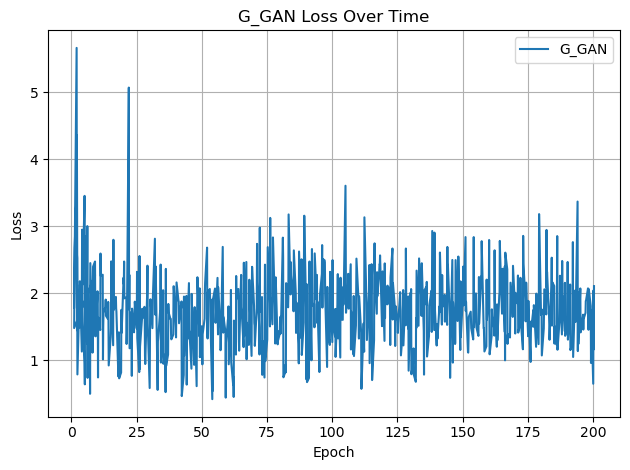

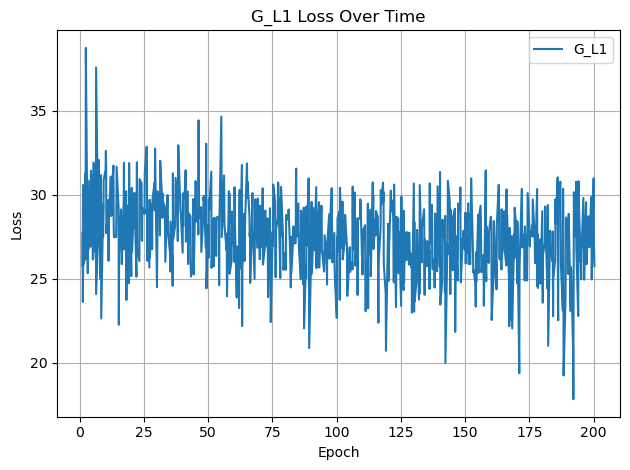

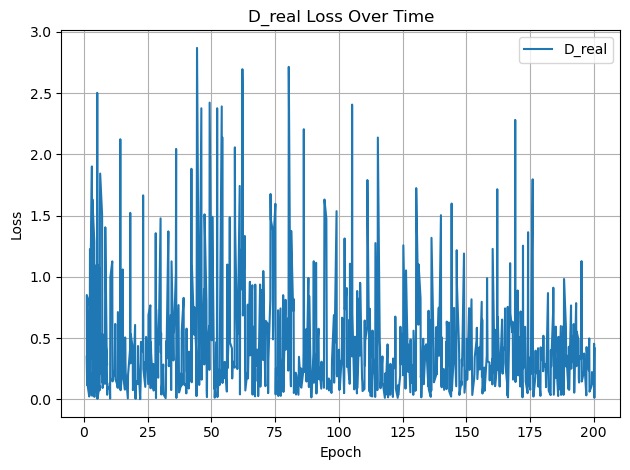

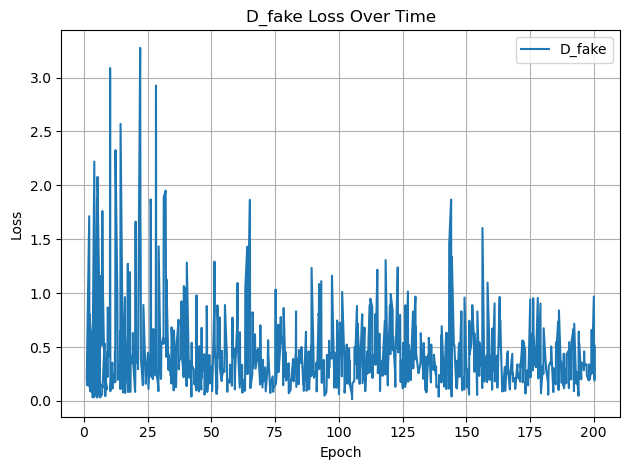

In [20]:
plot_losses_separately('/home/omerfarukaydin/Desktop/pytorch-CycleGAN-and-pix2pix/checkpoints/dataset_for_GAN_pix2pix/loss_log.txt')

In [ ]:
import matplotlib.pyplot as plt

img = plt.imread('./results/horse2zebra_pretrained/test_latest/images/n02381460_1010_fake.png')
plt.imshow(img)

In [ ]:
import matplotlib.pyplot as plt

img = plt.imread('./results/horse2zebra_pretrained/test_latest/images/n02381460_1010_real.png')
plt.imshow(img)